In [0]:
import time
import pandas as pd
import numpy as np
import datetime
import itertools
from google.colab import drive
from collections import defaultdict
from scipy.special import softmax
import pickle

In [2]:
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv('/content/gdrive/Shared drives/CS 238/time_series_60min_singleindex.csv')

In [0]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

In [8]:
data[:2]

,utc_timestamp,cet_cest_timestamp,AL_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BA_load_actual_entsoe_power_statistics,BE_load_actual_entsoe_power_statistics,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_offshore_generation_actual,BE_wind_onshore_capacity,BE_wind_onshore_generation_actual,BE_wind_onshore_profile,BG_load_actual_entsoe_power_statistics,BG_load_actual_entsoe_transparency,BG_load_forecast_entsoe_transparency,BG_solar_generation_actual,BG_wind_onshore_generation_actual,CH_load_actual_entsoe_power_statistics,CH_load_actual_entsoe_transparency,CH_load_forecast_entsoe_transparency,CH_solar_capacity,CH_solar_generation_actual,CH_wind_capacity,CH_wind_onshore_capacity,CH_wind_onshore_generation_actual,CS_load_actual_entsoe_power_statistics,CY_load_actual_entsoe_power_statistics,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,CZ_load_actual_entsoe_power_statistics,CZ_load_actual_entsoe_transparency,CZ_load_forecast_entsoe_transparency,CZ_solar_generation_actual,...,SE_load_actual_entsoe_transparency,SE_load_actual_tso,SE_load_forecast_entsoe_transparency,SE_price_day_ahead,SE_solar_generation_actual,SE_wind_generation_actual,SE_wind_onshore_generation_actual,SE_1_load_actual_entsoe_transparency,SE_1_load_forecast_entsoe_transparency,SE_1_price_day_ahead,SE_1_wind_onshore_generation_actual,SE_2_load_actual_entsoe_transparency,SE_2_load_forecast_entsoe_transparency,SE_2_price_day_ahead,SE_2_wind_onshore_generation_actual,SE_3_load_actual_entsoe_transparency,SE_3_load_forecast_entsoe_transparency,SE_3_price_day_ahead,SE_3_wind_onshore_generation_actual,SE_4_load_actual_entsoe_transparency,SE_4_load_forecast_entsoe_transparency,SE_4_price_day_ahead,SE_4_wind_onshore_generation_actual,SI_load_actual_entsoe_power_statistics,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_power_statistics,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,TR_load_actual_entsoe_power_statistics,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency,UA_east_load_actual_entsoe_transparency,UA_east_load_forecast_entsoe_transparency,UA_west_load_actual_entsoe_power_statistics,UA_west_load_actual_entsoe_transparency,UA_west_load_forecast_entsoe_transparency
0,2004-12-31 23:00:00+00:00,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-01 00:00:00+00:00,2005-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-15991.34,NaN,NaN,NaN,3.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
filter_col = ['utc_timestamp'] + [col for col in data if col.startswith('DE')]
data = data[filter_col]

data = data[data['utc_timestamp'] >= datetime.datetime(2015, 1, 1, tzinfo=datetime.timezone.utc)]
data = data[data['utc_timestamp'] < datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)]
data = data.reset_index().drop(columns=['index'])

In [0]:
columns = ['utc_timestamp', 'DE_load_actual_entsoe_transparency', 'DE_solar_generation_actual', 'DE_wind_generation_actual']
data = data[columns]

In [11]:
data.rename(columns={'utc_timestamp': 'timestamp', 'DE_load_actual_entsoe_transparency': 'load', 'DE_solar_generation_actual': 'solar', 'DE_wind_generation_actual': 'wind'}, inplace=True)
data[:2]

,timestamp,load,solar,wind
0,2015-01-01 00:00:00+00:00,40665.0,0.0,8814.0
1,2015-01-01 01:00:00+00:00,39510.0,0.0,9054.0


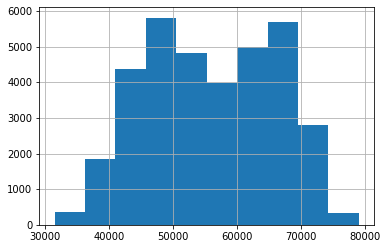

In [12]:
data['load'].hist()

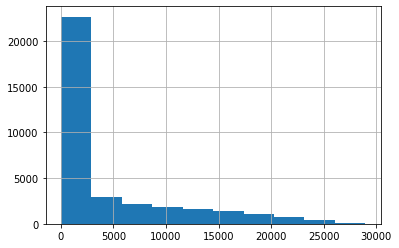

In [13]:
data['solar'].hist()

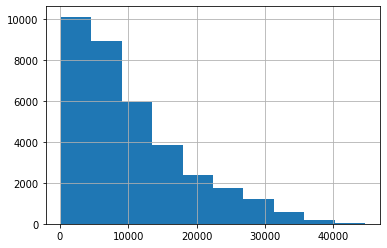

In [14]:
data['wind'].hist()

In [15]:
(data['load'] - data['solar'] - data['wind']).max()

72478.0

In [16]:
(data['load'] - data['solar'] - data['wind']).min()

5232.0

In [0]:
n_buckets = {
    'time_of_day': 12,
    'time_of_year': 4,
    'load_scaled': 10,
    'solar_scaled': 5,
    'wind_scaled': 9,
}

def scale(col, n_buckets):
  
  return (col - col.min()) / (col.max() - col.min()) * (n_buckets - 1)

In [18]:
data['time_of_day'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().hour), n_buckets['time_of_day'])
data['time_of_year'] = scale(data['timestamp'].apply(lambda timestamp: timestamp.to_pydatetime().month - 1 + (timestamp.to_pydatetime().day - 1) / 31.0), n_buckets['time_of_year'])
data['load_scaled'] = scale(data['load'], n_buckets['load_scaled'])
data['solar_scaled'] = scale(data['solar'], n_buckets['solar_scaled'])
data['wind_scaled'] = scale(data['wind'], n_buckets['wind_scaled'])

# for col, n in n_buckets.items():
#   print('{}:\t min={}\t max={}\t n_buckets={}'.format(col, data[col].min(), data[col].max(), n))
# print()
data[:2]

,timestamp,load,solar,wind,time_of_day,time_of_year,load_scaled,solar_scaled,wind_scaled
0,2015-01-01 00:00:00+00:00,40665.0,0.0,8814.0,0.000000,0.0,1.741094,0.0,1.560480
1,2015-01-01 01:00:00+00:00,39510.0,0.0,9054.0,0.478261,0.0,1.522748,0.0,1.603632


In [0]:
# STATE DISCRETIZATION
# time of day: 12 (every 2 hours from 0 to 24)
# time of year: 4 (every 3 months from 0 to 12)
# load: 10 (every 5k from 30k to 80k)
# solar: 5 (every 5k from 0 to 30k)
# wind: 9 (every 5k from 0 to 45k)
# plants on: 8 (# on)
#  - each outputs 1000 MW
# plants 1 hour out: 8
# plants 2 hours out: 8
# plants 3 hours out: 8
# plants 4 hours out: 8
# plants 5 hours out: 8

In [0]:
# Distance: Normalized euclidian distance for scaled columns

In [0]:
# Table: Q(s, a):
#  - default dict sparse grid
#  - default value: -725k (72478MW * 10)

In [0]:
# ACTIONS:
# number between +n and -n (+n: turn on n plants, -n: turn off n plants)

In [0]:
#Rewards:
# -5k for each plant running (there are now 16)
#+10*diff if diff is negative

In [0]:
train = data[data['timestamp'] < datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)] 
test = data[data['timestamp'] >= datetime.datetime(2018, 1, 1, tzinfo=datetime.timezone.utc)]
train[:2]
test[:2]

,timestamp,load,solar,wind,time_of_day,time_of_year,load_scaled,solar_scaled,wind_scaled
26304,2018-01-01 00:00:00+00:00,43342.0,0.0,33105.0,0.000000,0.0,2.247164,0.0,5.927990
26305,2018-01-01 01:00:00+00:00,42531.0,0.0,33868.0,0.478261,0.0,2.093850,0.0,6.065177


In [0]:
n = 16
gamma = 0.9
alpha = 0.1
def get_neighbor_weights(data_state):
  data_state = np.array(data_state)
  neighbors = list(itertools.product(*((np.floor(s), np.ceil(s)) for s in data_state)))
  weights = []
  for neighbor in neighbors:
    neighbor = np.array(neighbor)
    weights.append(np.linalg.norm(1 - np.abs(data_state - neighbor)))

  weights = np.array(weights)
  return neighbors, weights / weights.sum()


#gives you the valid actions from a given plant state
def get_valid_actions(plant_state):
  num_on = plant_state[0]
  num_off = n-sum(plant_state)
  return np.arange(-plant_state[0], num_off+1)


def get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights):
  Q_a = np.zeros(len(valid_actions))
  for i, action in enumerate(valid_actions):
    for j, neighbor_state in enumerate(neighbor_states):
      Q_a[i] += neighbor_weights[j] * Q[(neighbor_state + plant_state, action)]

  return Q_a


def update_plant_state(plant_state, action):
  if action >= 0:
    return (plant_state[0] + plant_state[1],) + plant_state[2:] + (action,)
  else:
    return (plant_state[0] + plant_state[1] + action,) + plant_state[2:] + (0,)

def get_data_state(row):
  return (row['time_of_day'], row['time_of_year'], row['load_scaled'], row['solar_scaled'], row['wind_scaled'])

In [0]:
Q = defaultdict(lambda: -725000.0)

for epoch in range(10000):
  print("epoch %d:" %epoch)
  plant_state = (0,0,0,0,0,0)

  st = time.time()
  n_rows = len(train)

  row = train.loc[0]
  data_state = get_data_state(row)
  neighbor_states, neighbor_weights = get_neighbor_weights(data_state)
  valid_actions = get_valid_actions(plant_state)
  Q_a = get_Q_values(data_state, plant_state, valid_actions, neighbor_states, neighbor_weights)

  for ind, row in train[:-1].iterrows():
    action = np.random.choice(valid_actions, p=softmax(Q_a))
    next_plant_state = update_plant_state(plant_state, action)

    next_row = train.loc[ind+1]
    diff = next_plant_state[0] * 5000.0 + next_row['solar'] + next_row['wind'] - next_row['load']
    reward = -5000.0*next_plant_state[0]
    if diff <0:
      reward += 10*diff
    next_data_state = get_data_state(next_row)
    next_valid_actions = get_valid_actions(next_plant_state)
    next_neighbor_states, next_neighbor_weights = get_neighbor_weights(next_data_state)
    next_Q_a = get_Q_values(next_data_state, next_plant_state, next_valid_actions, next_neighbor_states, next_neighbor_weights)
    for i, neighbor_state in enumerate(neighbor_states):
      key = (neighbor_state + plant_state, action)
      Q[key] += alpha * neighbor_weights[i] * (reward + gamma * max(next_Q_a) - Q[key])

    data_state = next_data_state
    neighbor_states = next_neighbor_states
    valid_actions = next_valid_actions
    Q_a = next_Q_a
    plant_state = next_plant_state

    if ind % 1000 == 0:
      print('finished row {} of {} in {:.2f} seconds ({:.2f}%)'.format(ind, n_rows, time.time() - st, ind/float(n_rows) * 100))
  if epoch %5 == 0:
    save_var = dict(Q)
    filename = "/content/gdrive/Shared drives/CS 238//Q_5_hour_fixed." +str(epoch)
    pickle.dump(save_var, open( filename, "wb" ) )
    print("saved Q after {} epochs to {}".format(epoch,filename))  


epoch 0:
finished row 0 of 26304 in 0.09 seconds (0.00%)
finished row 1000 of 26304 in 1.86 seconds (3.80%)
finished row 2000 of 26304 in 3.58 seconds (7.60%)
finished row 3000 of 26304 in 5.36 seconds (11.41%)
finished row 4000 of 26304 in 7.08 seconds (15.21%)
finished row 5000 of 26304 in 8.91 seconds (19.01%)
finished row 6000 of 26304 in 10.72 seconds (22.81%)
finished row 7000 of 26304 in 12.52 seconds (26.61%)
finished row 8000 of 26304 in 14.27 seconds (30.41%)
finished row 9000 of 26304 in 16.07 seconds (34.22%)
finished row 10000 of 26304 in 17.79 seconds (38.02%)
finished row 11000 of 26304 in 19.61 seconds (41.82%)
finished row 12000 of 26304 in 21.36 seconds (45.62%)
finished row 13000 of 26304 in 23.51 seconds (49.42%)
finished row 14000 of 26304 in 25.25 seconds (53.22%)
finished row 15000 of 26304 in 27.14 seconds (57.03%)
finished row 16000 of 26304 in 28.83 seconds (60.83%)
finished row 17000 of 26304 in 30.53 seconds (64.63%)
finished row 18000 of 26304 in 32.38 seco

In [0]:
Q = dict(Q)
pickle.dump( Q, open( "/content/gdrive/My Drive//variables.pickle", "wb" ) )



In [0]:
next(iter(Q))

In [0]:
del Q
next(iter(Q))

In [0]:
Q = pickle.load(open( "/content/gdrive/My Drive//variables.pickle", "rb" ) )

In [0]:
next(iter(Q))